In [25]:
import numpy as np
import sklearn.datasets

image_size = 8
no_of_different_labels = 10
image_pixels = image_size * image_size


data = sklearn.datasets.load_digits()

X = data['data']
Y = data['target']
one_hot = np.zeros((max(Y.shape), 10))
for i, label in enumerate(Y):
    one_hot[i][label] = 1
    



def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X, Y = unison_shuffled_copies(X, one_hot)

def partition(X, Y, fraction):
    n = int(len(Y)*(1-fraction))
    return X[n:], Y[n:], X[:n], Y[:n]

x_train, y_train, x_test, y_test = partition(X, Y, 0.8)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1438, 64) (1438, 10)
(359, 64) (359, 10)


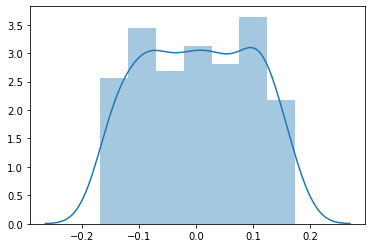

In [21]:
n = NeuralNetwork(64, 10, 32, .0001)
n.who.reshape(320)

sns.distplot(n.who.reshape(320))

In [35]:
import numpy as np

@np.vectorize
def sigmoid(x):
    return 1 / (1 + np.e ** -x)

activation_function = sigmoid

from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd,
                     (upp - mean) / sd,
                     loc=mean,
                     scale=sd)

class NeuralNetwork:
 
    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate,
                 bias=None
                ):  

        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        
        self.no_of_hidden_nodes = no_of_hidden_nodes
            
        self.learning_rate = learning_rate 
        self.bias = bias
        self.create_weight_matrices()
    
        
    
    def create_weight_matrices(self):
        """ 
        A method to initialize the weight matrices 
        of the neural network with optional 
        bias nodes"""
        
        bias_node = 1 if self.bias else 0
        
        rad = 1 / np.sqrt(self.no_of_in_nodes + bias_node)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.wih = X.rvs((self.no_of_hidden_nodes, 
                          self.no_of_in_nodes + bias_node))

        rad = 1 / np.sqrt(self.no_of_hidden_nodes + bias_node)
        X = truncated_normal(mean=0, 
                             sd=1, 
                             low=-rad, 
                             upp=rad)
        self.who = X.rvs((self.no_of_out_nodes, 
                          self.no_of_hidden_nodes + bias_node))
        
 
    def train_single(self, input_vector, target_vector):
        """
        input_vector and target_vector can be tuple, 
        list or ndarray
        """

        bias_node = 1 if self.bias else 0
        if self.bias:
            # adding bias node to the end of the inpuy_vector
            input_vector = np.concatenate((input_vector, [self.bias]))
        
        output_vectors = []
        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T
        
        output_vector1 = np.dot(self.wih, input_vector)
        output_hidden = activation_function(output_vector1)
        
        if self.bias:
            output_hidden = np.concatenate((output_hidden, 
                                            [[self.bias]]) )
        
        output_vector2 = np.dot(self.who, output_hidden)
        output_network = activation_function(output_vector2)
        
        output_errors = target_vector - output_network
                
        # update the weights:
        tmp = output_errors * output_network * (1.0 - output_network)          
        tmp = self.learning_rate * np.dot(tmp, output_hidden.T) 
        self.who += tmp

        
        # calculate hidden errors:
        hidden_errors = np.dot(self.who.T, output_errors)
        # update the weights:
        tmp = hidden_errors * output_hidden * (1.0 - output_hidden)
#         print(hidden_errors.shape)
#         print((output_hidden * (1.0 - output_hidden)).shape)
#         print(input_vector.shape) # (64,1)
#         print(tmp.shape) # (7,1)
        if self.bias:
            x = np.dot(tmp, input_vector.T)[:-1,:] 
        else:
            x = np.dot(tmp, input_vector.T)
        self.wih += self.learning_rate * x
        

    def train(self, data_array, 
              labels_one_hot_array,
              epochs=1,
              intermediate_results=False):
        
        intermediate_weights = []
        for epoch in range(epochs):  
            for i in range(len(data_array)):
                self.train_single(data_array[i], 
                                  labels_one_hot_array[i])
                
            if intermediate_results:
                intermediate_weights.append((self.wih.copy(), 
                                             self.who.copy()))
        return intermediate_weights      
        
    
    def run(self, input_vector):
        # input_vector can be tuple, list or ndarray
        
        if self.bias:
            # adding bias node to the end of the inpuy_vector
            input_vector = np.concatenate( (input_vector, 
                                            [self.bias]) )
        input_vector = np.array(input_vector, ndmin=2).T

        output_vector = np.dot(self.wih, 
                               input_vector)
        output_vector = activation_function(output_vector)
        
        if self.bias:
            output_vector = np.concatenate( (output_vector, 
                                             [[self.bias]]) )

        output_vector = np.dot(self.who, output_vector)
        output_vector = activation_function(output_vector)
    
        return output_vector
    
    
    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if labels[i][res_max]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs

In [39]:
epochs = 150

network = NeuralNetwork(no_of_in_nodes=image_pixels, 
                        no_of_out_nodes=10, 
                        no_of_hidden_nodes=32,
                        learning_rate=0.0001,
                        bias=1)

weights = network.train(x_train, 
                        y_train, 
                        epochs=epochs, 
                        intermediate_results=True) 


print('epoch\ttrain\t\t\ttest')
for epoch in range(epochs):  
    print(epoch, end='\t')
    network.wih = weights[epoch][0]
    network.who = weights[epoch][1]
    
    corrects, wrongs = network.evaluate(x_train, y_train) 
    print(corrects / ( corrects + wrongs), end='\t')
    
    corrects, wrongs = network.evaluate(x_test, y_test)
    print(corrects / ( corrects + wrongs))
    

epoch	train			test
0	0.1404728789986092	0.1309192200557103
1	0.1564673157162726	0.13649025069637882
2	0.13630041724617525	0.11420612813370473
3	0.1376912378303199	0.116991643454039
4	0.1383866481223922	0.11977715877437325
5	0.1474269819193324	0.12813370473537605
6	0.1627260083449235	0.14763231197771587
7	0.1835883171070932	0.17827298050139276
8	0.20166898470097358	0.19220055710306408
9	0.21835883171070933	0.2116991643454039
10	0.2329624478442281	0.2200557103064067
11	0.24965229485396384	0.2479108635097493
12	0.26495132127955495	0.25348189415041783
13	0.28442280945758	0.2785515320334262
14	0.30598052851182195	0.28969359331476324
15	0.3282336578581363	0.31197771587743733
16	0.347009735744089	0.3342618384401114
17	0.3678720445062587	0.3342618384401114
18	0.3991655076495132	0.3565459610027855
19	0.4207232267037552	0.37604456824512533
20	0.44019471488178025	0.3816155988857939
21	0.4513212795549374	0.38997214484679665
22	0.456884561891516	0.39275766016713093
23	0.4631432545201669	0.398328690

In [31]:
y_train[0][0] ==1 

True

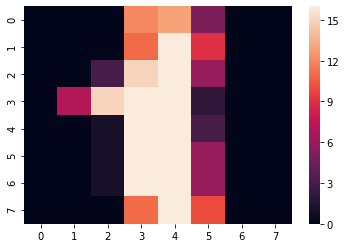

In [10]:
import seaborn as sns
sns.heatmap(X[1].reshape(8,8))

In [47]:
inputs = X.T
outputs = Y.T

shape = [64, 2, 10]

weights = generate_network(shape)
training_rate = 0.01
weights = train_network_main(inputs, outputs, training_rate, shape, weights)


In [40]:
# test_input = np.array([[0, 0, 1, 1]]).T
test_input = np.array([X[2]]).T

run_network(test_input, shape, weights)

NameError: name 'run_network' is not defined

In [41]:
np.array([[1,2], [3,4]])

array([[1, 2],
       [3, 4]])

In [ ]:
if learning_rate == 'constant':
    learning_rate_current = learning_rate_init
if learning_rate == 'adaptive':
    learning_rate_current = learning_rate_init * (.8)**epoch